In [1]:
import json
import sys
import warnings
from typing import Any, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
name: Any
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from src.config import app_settings  # noqa: E402
from src.utilities.model_config import RemoteModel  # noqa: E402

settings = app_settings

/Users/mac/Desktop/Projects/smart-rag


In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!


In [5]:
from langchain.tools import tool

#### Create Tools

In [6]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    api_key=settings.TAVILY_API_KEY.get_secret_value(),
    max_results=2,
    topic="general",
)
search_response = tavily_search.invoke({"query": "What is agentic RAG?"})
search_response

{'query': 'What is agentic RAG?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/artificial-intelligence/what-is-agentic-rag/',
   'title': 'What is Agentic RAG? - GeeksforGeeks',
   'content': 'Agentic RAG is an advanced version of Retrieval-Augmented Generation (RAG) where an AI agent retrieves external information and autonomously decides how to use that data. Single-Agent RAG uses a single intelligent agent that routes each user query to the most appropriate data source or tool. * By optimizing the data retrieval process, it improves the responsiveness and accuracy of agents within Agentic RAG systems which ensures that the system can retrieve the most relevant data and generate more accurate responses for complex tasks. Using the framework like LangGraph into Agentic RAG systems can increase their performance, adaptability and scalability which leads to the development of more intelligent, responsive and efficient 

In [7]:
import httpx
from markdownify import markdownify


async def afetch_raw_content(url: str) -> str | None:
    """
    Asynchronously fetch HTML content from a URL and convert it to markdown format.

    Parameters
    ----------
    url : str
        The URL to fetch content from.

    Returns
    -------
    str or None
        The fetched content converted to markdown if successful,
        None if any error occurs during fetching or conversion.

    Notes
    -----
    Uses a 10-second timeout to avoid hanging on slow sites or large pages.
    """
    try:
        # Create a client with reasonable timeout
        async with httpx.AsyncClient() as client:
            response = await client.get(url, timeout=10)
            response.raise_for_status()
            return markdownify(response.text)
    except Exception as e:
        print(f"Warning: Failed to fetch full page content for {url}: {str(e)}")
        return None


# await afetch_raw_content(url)

In [8]:
from langchain_community.tools import DuckDuckGoSearchResults

In [9]:
search = DuckDuckGoSearchResults(output_format="list")

search.invoke("Obama's first name?")

[{'snippet': 'Michelle LaVaughn Robinson Obama[1] (née Robinson; born January 17, 1964) is an American attorney and author who served as the first lady of the United States from 2009 to 2017, as the wife of Barack Obama , the 44th president of the United States. Born in Chicago and raised on the South Side of the city, Obama is a graduate of Princeton University and Harvard Law School. In her early legal ...',
  'title': 'Michelle Obama - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Michelle_Obama'},
 {'snippet': 'In February 1981, Obama made his first public speech, calling for Occidental to participate in the disinvestment from South Africa in response to ...',
  'title': 'Barack Obama - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Barack_Obama'},
 {'snippet': 'Barack Obama , the 44th President of the United States, broke barriers as the first African-American president and implemented significant healthcare reforms during his tenure.',
  'title': 'Barack Obama | Biog

In [10]:
from langchain_community.utilities import GoogleSerperAPIWrapper


async def duckduckgo_search(
    query: str, fetch_full_page: bool = False
) -> dict[str, list[dict[str, Any]]]:
    try:
        search = DuckDuckGoSearchResults(output_format="list")
        raw_results = await search.ainvoke(query)

        # format the data
        raw_results: list[dict[str, Any]] = [
            {
                "title": row["title"],
                "url": row["link"],
                "content": row["snippet"],
            }
            for row in raw_results
        ]

        if fetch_full_page:
            raw_results = [
                {
                    **row,
                    **{
                        "raw_content": await afetch_raw_content(row["url"]),
                    },
                }
                for row in raw_results
            ]
        return {"results": raw_results}

    except Exception as e:
        print(f"Duckduckgo search failed: {str(e)}")
        return {"results": []}


async def google_search(
    query: str, max_results: int = 3, fetch_full_page: bool = False
) -> dict[str, list[dict[str, Any]]]:
    """
    Perform a web search using the GoogleSerperAPIWrapper.

    Parameters
    ----------
    query : str
        The search query string.
    max_results : int, optional
        Maximum number of results to return (default is 3).
    fetch_full_page : bool, optional
        If True, fetch and include the full page content for each result (default is False).

    Returns
    -------
    dict[str, list[dict[str, Any]]]
        Dictionary with a "results" key containing a list of result dictionaries.
        Each result dictionary contains:
            - "title": str, the result title
            - "url": str, the result URL
            - "content": str, the snippet or summary
            - "raw_content": str, the full page content if fetched, otherwise the snippet

    Notes
    -----
    Uses the GoogleSerperAPIWrapper for querying Google Serper. Handles errors gracefully.
    """
    search = GoogleSerperAPIWrapper(k=max_results)

    try:
        raw_results = await search.aresults(query)

        results = [
            {
                "title": res["title"],
                "url": res["link"],
                "content": res["snippet"],
                "raw_content": res["snippet"],
            }
            for res in raw_results["organic"]
        ]
        if fetch_full_page:
            results = [
                {
                    **row,
                    **{
                        "raw_content": await afetch_raw_content(row["url"]),
                    },
                }
                for row in results
            ]
        return {"results": results}

    except Exception as e:
        print(f"Google search failed: {str(e)}")
        return {"results": []}

In [11]:
res = await duckduckgo_search(
    "What was the result of Barcelona vs Madrid today?", fetch_full_page=True
)

For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403


In [12]:
res = await google_search(
    "What was the result of Barcelona vs Madrid today?", fetch_full_page=True
)

In [13]:
res

{'results': [{'title': 'Real Madrid 2-1 Barcelona (Oct 26, 2025) Game Analysis - ESPN',
   'url': 'https://www.espn.com/soccer/report/_/gameId/748236',
   'content': 'Real Madrid ended its four-game losing streak against rival Barcelona with a 2-1 victory in the first El Clásico of the season on Sunday.',
   'raw_content': "Real Madrid 2-1 Barcelona (Oct 26, 2025) Game Analysis - ESPN\n\n\n\n\nSkip to main contentSkip to navigation\n\n[ESPN](/)\n\n* [NFL](/nfl/)NFL\n\n* [NBA](/nba/)NBA\n\n* [MLB](/mlb/)MLB\n\n* [NCAAF](/college-football/)NCAAF\n\n* [NHL](/nhl/)NHL\n\n* [Soccer](/soccer/)Soccer\n\n* [WNBA](/wnba/)WNBA\n\n* [More Sports](#)More Sports\n\n* [ESPN BET\n\n  Watch](http://www.espn.com/watch/)Watch\n\n* [ESPN BET\n\n  Bet](https://espnbet.app.link/V424mquT4Eb?$3p=a_espn)ESPN BET\n\n* [ESPN BET\n\n  Fantasy](/fantasy/)Fantasy\n\n* [Where to Watch](https://www.espn.com/where-to-watch)\n\n* Search\n\nReal Madrid v Barcelona\n=======================\n\n2025-26 LALIGA\n\n[![RMA](h

In [14]:
console.print(res["results"][2]["raw_content"][:1500])

How did Real Madrid DEFEAT Barcelona in El Clásico? | Numbers Don't Lie - 
YouTube[About](https://www.youtube.com/about/)[Press](https://www.youtube.com/about/press/)[Copyright](https://www.
youtube.com/about/copyright/)[Contact 
us](/t/contact_us/)[Creator](https://www.youtube.com/creators/)[Advertise](https://www.youtube.com/ads/)[Developers
](https://developers.google.com/youtube)[Terms](/t/terms)[Privacy](/t/privacy)[Policy & 
Safety](https://www.youtube.com/about/policies/)[How YouTube 
works](https://www.youtube.com/howyoutubeworks?utm_campaign=ytgen&utm_source=ythp&utm_medium=LeftNav&utm_content=tx
t&u=https%3A%2F%2Fwww.youtube.com%2Fhowyoutubeworks%3Futm_source%3Dythp%26utm_medium%3DLeftNav%26utm_campaign%3Dytg
en)[Test new features](/new)

© 2025 Google LLC

In [15]:
import calendar
from datetime import datetime


def day_name_tool(year: int, month: int, day: int) -> str:
    """Determine the name of the day for a given date.
    Parameters
    ----------
    year : int
        The year for which to generate the calendar (e.g., 2025).
    month : int
        The month for which to generate the calendar (1-12).
    day : int
        The day of the month (not used in calendar generation).

    Returns
    -------
    str
        The name of the day for the given date.
    """
    if not isinstance(year, int) or year < 1:
        raise ValueError("Year must be a positive integer.")
    if not isinstance(month, int):
        raise ValueError("Month must be an integer.")
    if not isinstance(day, int):
        raise ValueError("Day must be an integer.")
    if not (1 <= month <= 12):
        raise ValueError("Month must be between 1 and 12.")
    if not (1 <= day <= 31):
        raise ValueError("Day must be between 1 and 31.")

    return calendar.day_name[calendar.weekday(year, month, day)]


@tool(response_format="content_and_artifact")
async def search_tool(query: str, max_chars: int = 500) -> tuple[str, dict]:
    """Perform a search using TavilySearch tool.

    Parameters:
    -----------
    query: str
        The search query.
    max_chars: int, default=1000
        The maximum number of characters per source to return from the search results.

    Returns:
    --------
    str
        The formatted search results.
    """
    separator: str = "\n\n"

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=3,
        topic="general",
    )
    search_response = await tavily_search.ainvoke({"query": query})
    formatted_results: str = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content'][:max_chars]} [truncated]\nURL: {result['url']}{separator}"
        for result in search_response["results"]
    )
    return formatted_results, search_response


@tool(response_format="content")
def date_and_time_tool() -> str:
    """
    Get the current date, time, and day name as a string.

    Returns
    -------
    str
        The current date, time, and day name as a string.
    """
    raw_date: str = datetime.now().isoformat()
    date: str = raw_date.split("T")[0]
    time: str = raw_date.split("T")[-1]

    day_name: str = day_name_tool(
        year=int(date.split("-")[0]),
        month=int(date.split("-")[1]),
        day=int(date.split("-")[2]),
    )

    return f"Date: {date}\n\nTime: {time} (GMT+1)\n\nDay Name: {day_name}"

In [16]:
console.print(search_tool)

StructuredTool(
    name='search_tool',
    description='Perform a search using TavilySearch tool.\n\n    Parameters:\n    -----------\n    query: str\n   
The search query.\n    max_chars: int, default=1000\n        The maximum number of characters per source to return 
from the search results.\n\n    Returns:\n    --------\n    str\n        The formatted search results.',
    args_schema=<class 'langchain_core.utils.pydantic.search_tool'>,
    response_format='content_and_artifact',
    coroutine=<function search_tool at 0x132e4ff60>
)

In [17]:
formatted_results, search_response = await search_tool.coroutine("what is agentic RAG?")
console.print(formatted_results)

Title: What is Agentic RAG? | IBM
Content: # What is agentic RAG? Agentic RAG is the use of AI agents to facilitate retrieval augmented generation 
(RAG). Agentic RAG systems add AI agents to the RAG pipeline to increase adaptability and accuracy. ### What is 
agentic AI? AI agents ### What are AI agents? From monolithic models to compound AI systems, discover how AI agents
integrate with databases and external tools to enhance problem-solving capabilities and adaptability. ## How does 
agentic RAG work? Agentic RAG works by incorporating o 
URL: https://www.ibm.com/think/topics/agentic-rag



Title: Agentic RAG: How It Works, Use Cases, Comparison With RAG
Content: Learn about Agentic RAG, an AI paradigm combining agentic AI and RAG for autonomous information access and
generation. Agentic RAG combines agentic AI’s decision-making with RAG’s ability to pull in dynamic data. By 
continuously analyzing the context and user intent, agentic RAG systems can autonomously retrieve and integrate 
relevant information from diverse sources, including real-time data streams and external APIs. This proactive 
approach enables them to generate comprehensive and contextual 
URL: https://www.datacamp.com/blog/agentic-rag



Title: Agentic RAG explained: Smarter retrieval with AI agents - Glean
Content: * **Agentic RAG Overview**: Agentic RAG enhances traditional retrieval-augmented generation (RAG) by 
incorporating autonomous AI agents, enabling real-time decision-making, adaptive workflows, and deeper reasoning 
suited for complex tasks. * **Key Differences from Traditional RAG**: Unlike traditional RAG, which follows a 
static workflow, agentic RAG allows AI agents to adapt retrieval processes based on findings, validate context 
dynamically, and tackle multi-faceted tasks through specializatio 
URL: https://www.glean.com/blog/agentic-rag-explained

In [18]:
console.print(search_response)

{
    'query': 'what is agentic RAG?',
    'follow_up_questions': None,
    'answer': None,
    'images': [],
    'results': [
        {
            'url': 'https://www.ibm.com/think/topics/agentic-rag',
            'title': 'What is Agentic RAG? | IBM',
            'content': '# What is agentic RAG? Agentic RAG is the use of AI agents to facilitate retrieval 
augmented generation (RAG). Agentic RAG systems add AI agents to the RAG pipeline to increase adaptability and 
accuracy. ### What is agentic AI? AI agents ### What are AI agents? From monolithic models to compound AI systems, 
discover how AI agents integrate with databases and external tools to enhance problem-solving capabilities and 
adaptability. ## How does agentic RAG work? Agentic RAG works by incorporating one or more types of AI agents into 
RAG systems. Agentic RAG systems can contain one or more types of AI agents, such as: Report   Agentic AI products 
to watch out for in 2025  AI agents for business    IBM AI agent solutions    Explore AI agent solutions   ',
            'score': 0.9393874,
            'raw_content': None
        },
        {
            'url': 'https://www.datacamp.com/blog/agentic-rag',
            'title': 'Agentic RAG: How It Works, Use Cases, Comparison With RAG',
            'content': 'Learn about Agentic RAG, an AI paradigm combining agentic AI and RAG for autonomous 
information access and generation. Agentic RAG combines agentic AI’s decision-making with RAG’s ability to pull in 
dynamic data. By continuously analyzing the context and user intent, agentic RAG systems can autonomously retrieve 
and integrate relevant information from diverse sources, including real-time data streams and external APIs. This 
proactive approach enables them to generate comprehensive and contextually relevant responses without requiring 
explicit human intervention. Agentic RAG combines the autonomy of agentic systems with the dynamic data retrieval 
of RAG. Learn how to use n8n to build AI agents that automate email processing and create a retrieval-augmented 
generation (RAG) agent for document question answering.',
            'score': 0.9197076,
            'raw_content': None
        },
        {
            'url': 'https://www.glean.com/blog/agentic-rag-explained',
            'title': 'Agentic RAG explained: Smarter retrieval with AI agents - Glean',
            'content': '* **Agentic RAG Overview**: Agentic RAG enhances traditional retrieval-augmented generation
(RAG) by incorporating autonomous AI agents, enabling real-time decision-making, adaptive workflows, and deeper 
reasoning suited for complex tasks. * **Key Differences from Traditional RAG**: Unlike traditional RAG, which 
follows a static workflow, agentic RAG allows AI agents to adapt retrieval processes based on findings, validate 
context dynamically, and tackle multi-faceted tasks through specialization and collaboration. That’s where agentic 
RAG comes in — an approach that embeds autonomous AI agents into the retrieval pipeline to enable deeper reasoning,
smarter routing, and more adaptive workflows. It enhances traditional RAG systems by incorporating AI agents — 
autonomous components that make decisions, plan actions, and coordinate with tools or other agents in real time.',
            'score': 0.9197076,
            'raw_content': None
        }
    ],
    'response_time': 0.97,
    'request_id': '4109db11-2afe-4c3f-9468-15cd7bb05378'
}

In [19]:
date_and_time_tool.func()

# console.print(date_tool)

'Date: 2025-10-28\n\nTime: 23:30:08.814916 (GMT+1)\n\nDay Name: Tuesday'

In [20]:
chatbot_system_message = """
<SYSTEM>
    <ROLE>You are a knowledgeable and helpful chatbot assistant.</ROLE>

    <GUIDELINES>
    - Provide clear, accurate, and contextually relevant answers based on the user's input.
    - Use available tools to ensure responses are current and reliable.
    - Keep responses focused, concise, and directly related to the conversation.
    - If information is insufficient, politely ask for clarification.
    - Limit responses to a maximum of five sentences.
    </GUIDELINES>
</SYSTEM>
"""

query_prompt: str = """
<USER>
    <QUERY>{query}</QUERY>
</USER>
"""

summary_prompt: str = """
<USER>
    <GUIDELINES>
        - Expand the summary by incorporating the the above conversation while preserving context, key points, and
        user intent. 
        - Rework the summary if needed. Ensure that no critical information is lost and that the 
        conversation can continue naturally without gaps. 
        - Keep the summary concise yet informative, removing unnecessary repetition while maintaining clarity.
        - Only return the updated summary. Do not add explanations, section headers, or extra commentary.
    </GUIDELINES>

    <SUMMARY>{summary}</SUMMARY>

</USER>
"""

no_summary_prompt: str = """
<USER>
    <GUIDELINES>
    - Summarize the conversation above while preserving full context, key points, and user intent. 
    - Your response should be concise yet detailed enough to ensure seamless continuation of the discussion.
    - Avoid redundancy, maintain clarity, and retain all necessary details for future exchanges.
    - Only return the summarized content. Do not add explanations, section headers, or extra commentary.
    </GUIDELINES>

</USER>
"""

In [21]:
# from typing import Annotated, TypedDict
# from uuid import uuid4

# from IPython.display import Image, Markdown, display
# from langchain.messages import RemoveMessage
# from langchain_core.messages import (
#     AIMessage,
#     AnyMessage,
#     HumanMessage,
#     SystemMessage,
#     ToolMessage,
# )
# from langchain_core.messages.utils import count_tokens_approximately
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph import END, START, StateGraph
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy
# from langmem.short_term import RunningSummary, SummarizationNode
# from pydantic import BaseModel

In [22]:
from typing import Annotated, TypedDict

from langchain.messages import RemoveMessage
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
)
from langgraph.graph.message import add_messages

### Remove Messages

In [23]:
existing_msgs = [
    HumanMessage(content="Message 1", id=1),
    AIMessage(content="Message 2", id=2),
    HumanMessage(content="Message 3", id=3),
    AIMessage(
        content="Message 4",
        id=4,
    ),
    HumanMessage(content="Message 5", id=5),
]

new_messages = [
    AIMessage(
        content="Message 6",
        id=6,
    ),
    HumanMessage(content="Message 7", id=7),
    AIMessage(content="Message 8", id=8),
]

messages = add_messages(existing_msgs, new_messages)
messages

[HumanMessage(content='Message 1', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Message 2', additional_kwargs={}, response_metadata={}, id='2'),
 HumanMessage(content='Message 3', additional_kwargs={}, response_metadata={}, id='3'),
 AIMessage(content='Message 4', additional_kwargs={}, response_metadata={}, id='4'),
 HumanMessage(content='Message 5', additional_kwargs={}, response_metadata={}, id='5'),
 AIMessage(content='Message 6', additional_kwargs={}, response_metadata={}, id='6'),
 HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7'),
 AIMessage(content='Message 8', additional_kwargs={}, response_metadata={}, id='8')]

In [24]:
# Remove messages except the last 2
messages_to_remove = [RemoveMessage(id=m.id) for m in messages[:-2]]
messages_to_remove

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='5'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='6')]

In [25]:
updated_messages = add_messages(messages, messages_to_remove)
updated_messages

[HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7'),
 AIMessage(content='Message 8', additional_kwargs={}, response_metadata={}, id='8')]

In [27]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import RetryPolicy

In [32]:
# ===============================================================
# =========================== STATES ============================
# ===============================================================
class MetaState(TypedDict):
    query: str
    answer: str

    messages: Annotated[list[AnyMessage], add_messages]


class State(MetaState):
    summary: str


# ===============================================================
# ============================ LLMS =============================
# ===============================================================
MAX_SUMMARY_TOKENS: int = 2048
MAX_MESSAGES: int = 20

llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.02,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)
summarization_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.QWEN3_30B_A3B,
).bind(max_tokens=MAX_SUMMARY_TOKENS)


# ===============================================================
# ============================ NODES ============================
# ===============================================================
async def call_llm(state: State) -> State:
    summary: str = state.get("summary", "")
    sys_msg = SystemMessage(content=chatbot_system_message)

    if summary:
        summary_msg = SystemMessage(content=f"Summary of conversation:\n\n {summary}")
        # Summary + most recent messages
        msgs_with_summary = [summary_msg] + state["messages"]

    else:
        msgs_with_summary = state["messages"]

    _msg = query_prompt.format(query=state.get("query", ""))
    query = HumanMessage(content=_msg)
    llm_with_tools = llm.bind_tools(tools=[search_tool, date_and_time_tool])
    response = await llm_with_tools.ainvoke([sys_msg] + msgs_with_summary + [query])

    return State(
        query=state.get("query", ""),
        answer=response.content,
        messages=[state.get("query", ""), response],
        summary=summary,
    )


async def summarization_node(state: State) -> State:
    summary: str = state.get("summary", "")

    if summary:
        summary_msg: list[AnyMessage] = [
            HumanMessage(content=summary_prompt.format(summary=summary))
        ]
    else:
        summary_msg = [HumanMessage(content=no_summary_prompt)]

    response: AIMessage = await summarization_llm.ainvoke(
        state["messages"] + summary_msg
    )

    # Delete ALL but the last 2 messages
    messages_to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return State(
        query=state.get("query", None),
        answer=state.get("answer", None),
        messages=messages_to_remove,
        summary=response.content,
    )


# ===============================================================
# =========================== EDGEs =============================
# ===============================================================
def should_summarize(state: State) -> Literal["summarize", END]:
    if len(state["messages"]) > MAX_MESSAGES:
        return "summarize"

    return END

In [33]:
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy

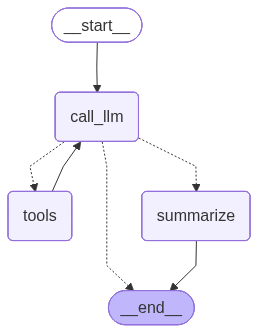

In [34]:
max_attempts: int = 2

# Memory
memory = MemorySaver()
tool_node = ToolNode([search_tool, date_and_time_tool])
builder = StateGraph(State)

# Add Nodes
builder.add_node(
    "call_llm",
    call_llm,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)
builder.add_node(
    "tools",
    tool_node,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)
builder.add_node(
    "summarize",
    summarization_node,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)

# Add Edges
# builder.add_conditional_edges(
#     START, should_summarize, {"summarize": "summarize", "call_llm": "call_llm"}
# )
builder.add_edge(START, "call_llm")
# builder.add_edge("call_llm", "summarize")
builder.add_conditional_edges("call_llm", tools_condition, {"tools": "tools", END: END})
builder.add_conditional_edges(
    "call_llm", should_summarize, {"summarize": "summarize", END: END}
)
builder.add_edge("tools", "call_llm")

# Build the graph
graph = builder.compile(checkpointer=memory)


# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [35]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-01"}}
response = await graph.ainvoke(
    {"query": HumanMessage("Hello, I'm neidu. Tell me a joke")},
    config=config,  # type: ignore
)

# for message in response["messages"][-2:]:
#     message.pretty_print()

response

{'query': HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='7fe75486-70c4-4ff6-8b37-588804f4b25c'),
 'answer': "Why don't scientists trust atoms? Because they make up everything!\n",
 'messages': [HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='7fe75486-70c4-4ff6-8b37-588804f4b25c'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 281, 'total_tokens': 293, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1761690702-6oigdLPBqAcHAuxUBewZ', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc

In [37]:
# msg: str = "Who was the first Nigerian Catholic priest in Nigeria?"
msg: str = "What's today's date? and What day is tomorrow?"
# msg: str = "What is my name?"
# msg: str = "What is langgraph? Which is better between langgraph and AutoGen?"
response = await graph.ainvoke({"query": HumanMessage(msg)}, config=config)

# for message in response["messages"][-2:]:
#     message.pretty_print()

response

{'query': HumanMessage(content="What's today's date? and What day is tomorrow?", additional_kwargs={}, response_metadata={}, id='725a093d-bd97-45ba-afee-95bc009df75e'),
 'answer': 'Today is Tuesday, October 28, 2025. Tomorrow will be Wednesday.\n',
 'messages': [HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='7fe75486-70c4-4ff6-8b37-588804f4b25c'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 281, 'total_tokens': 293, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1761690702-6oigdLPBqAcHAuxUBewZ', 'finish_reason': 'tool_calls', 'logprobs': No

In [38]:
len(response["messages"])

10

In [41]:
# get the latest state snapshot
print(graph.get_state(config))

StateSnapshot(values={'query': HumanMessage(content="What's today's date? and What day is tomorrow?", additional_kwargs={}, response_metadata={}, id='725a093d-bd97-45ba-afee-95bc009df75e'), 'answer': 'Today is Tuesday, October 28, 2025. Tomorrow will be Wednesday.\n', 'messages': [HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='7fe75486-70c4-4ff6-8b37-588804f4b25c'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 281, 'total_tokens': 293, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1761690702-6oigdLPBqAcHAuxUBewZ', 'finish_reason': 'tool_calls

In [42]:
# State history
list(graph.get_state_history(config))

[StateSnapshot(values={'query': HumanMessage(content="What's today's date? and What day is tomorrow?", additional_kwargs={}, response_metadata={}, id='725a093d-bd97-45ba-afee-95bc009df75e'), 'answer': 'Today is Tuesday, October 28, 2025. Tomorrow will be Wednesday.\n', 'messages': [HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='7fe75486-70c4-4ff6-8b37-588804f4b25c'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 281, 'total_tokens': 293, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1761690702-6oigdLPBqAcHAuxUBewZ', 'finish_reason': 'tool_call

### Streaming

In [43]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-02"}}
response = graph.astream(
    {"query": HumanMessage("Hello, I'm neidu")},
    config=config,  # type: ignore
    stream_mode="values",
)

async for chunk in response:
    print(chunk)

{'query': HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}), 'messages': []}
{'query': HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='1b06fe7c-0925-4453-bee0-7651c564383f'), 'answer': 'Hello neidu, how can I help you today?\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='1b06fe7c-0925-4453-bee0-7651c564383f'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-17

In [44]:
response = graph.astream(
    {"query": HumanMessage("What's my name?")},
    config=config,  # type: ignore
    stream_mode="messages",
)

async for chunk in response:
    print(chunk)

(AIMessageChunk(content='Your', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--8deee4ca-af7e-4daa-b356-1cf7f145d256'), {'thread_id': 'test-02', 'langgraph_step': 4, 'langgraph_node': 'call_llm', 'langgraph_triggers': ('branch:to:call_llm',), 'langgraph_path': ('__pregel_pull', 'call_llm'), 'langgraph_checkpoint_ns': 'call_llm:50a11093-0f0f-0347-2d03-064392f3243a', 'checkpoint_ns': 'call_llm:50a11093-0f0f-0347-2d03-064392f3243a', 'ls_provider': 'openai', 'ls_model_name': 'google/gemini-2.0-flash-001', 'ls_model_type': 'chat', 'ls_temperature': 0.02})
(AIMessageChunk(content=' name is neidu.\n', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'google/gemini-2.0-flash-001', 'model_provider': 'openai'}, id='lc_run--8deee4ca-af7e-4daa-b356-1cf7f145d256', chunk_position='last'), {'thread_id': 'test-02', 'langgraph_step': 4, 'langgraph_node': 'call_llm', 'langgraph_triggers': ('branch:to:call_llm',), 'langgraph_path': ('__preg

<br>

### Real-time Response Streaming (astream_events)

- Use `astream_events` to get real-time events as they occur in the graph execution.
- Useful for creating dynamic UIs or dashboards that update in real-time.

In [45]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"query": HumanMessage("What is today's date and time?")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content="What is today's date and time?", additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2fd99136-6b67-4396-8dd3-a252638af5a0', 'metadata': {'thread_id': 'test-02'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content="What is today's date and time?", additional_kwargs={}, response_metadata={}), 'answer': 'Your name is neidu.\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='1b06fe7c-0925-4453-bee0-7651c564383f'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, '

In [46]:
# Generate real-time events
response = graph.astream_events(
    {"query": HumanMessage("Please verify that for me.")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    if chunk.get("event") == "on_chat_model_end":
        print(chunk.get("data").get("output").content)

Could you please clarify what you would like me to verify?



In [47]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"query": HumanMessage("Where did Peter Obi study?")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content='Where did Peter Obi study?', additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019b3270-5bc0-4e4e-801b-2916a3cdb0f0', 'metadata': {'thread_id': 'test-02'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content='Where did Peter Obi study?', additional_kwargs={}, response_metadata={}), 'answer': 'Could you please clarify what you would like me to verify?\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='1b06fe7c-0925-4453-bee0-7651c564383f'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_token

In [ ]:
{
    "event": "on_chat_model_end",
    "data": {
        "output": AIMessage(
            content="",
            additional_kwargs={},
            response_metadata={
                "finish_reason": "tool_calls",
                "model_name": "openai/gpt-oss-20b",
                "model_provider": "openai",
            },
            id="lc_run--00f6ab86-4e41-49f9-b407-b7f868de6366",
            tool_calls=[
                {
                    "name": "search_tool",
                    "args": {
                        "query": "Peter Obi education where did he study",
                        "max_chars": 500,
                    },
                    "id": "functions.search_tool_134c",
                    "type": "tool_call",
                }
            ],
            usage_metadata={
                "input_tokens": 334,
                "output_tokens": 56,
                "total_tokens": 390,
                "input_token_details": {},
                "output_token_details": {},
            },
        ),
        "input": {
            "messages": [
                [
                    HumanMessage(
                        content="Hello, I'm neidu",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="Hello Neidu! 👋 How can I help you today?",
                        additional_kwargs={"refusal": None},
                        response_metadata={
                            "token_usage": {
                                "completion_tokens": 50,
                                "prompt_tokens": 192,
                                "total_tokens": 242,
                                "completion_tokens_details": None,
                                "prompt_tokens_details": None,
                            },
                            "model_provider": "openai",
                            "model_name": "openai/gpt-oss-20b",
                            "system_fingerprint": None,
                            "id": "gen-1761438180-BZ1Pe6JAyGcYGUc0s09C",
                            "finish_reason": "stop",
                            "logprobs": None,
                        },
                        id="lc_run--bdd6d5c6-f7fe-49d9-b9ef-8212b73be0be-0",
                        usage_metadata={
                            "input_tokens": 192,
                            "output_tokens": 50,
                            "total_tokens": 242,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="What's my name?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="You’re Neidu!",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "model_provider": "openai",
                        },
                        id="lc_run--c1bdfa40-81d9-4e1e-9ae9-ff3f2877d00e",
                        usage_metadata={
                            "input_tokens": 219,
                            "output_tokens": 42,
                            "total_tokens": 261,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="Are you sure?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="Yes—I’m remembering that you introduced yourself as “Neidu.” If that’s not correct or you’d like me to use a different name, just let me know!",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "system_fingerprint": "fp_e189667b30",
                            "model_provider": "openai",
                        },
                        id="lc_run--306354b6-872b-4560-a146-6e6567c35a35",
                        usage_metadata={
                            "input_tokens": 249,
                            "output_tokens": 87,
                            "total_tokens": 336,
                            "input_token_details": {},
                            "output_token_details": {"reasoning": 44},
                        },
                    ),
                    HumanMessage(
                        content="Please verify that for me.",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                    AIMessage(
                        content="I’m remembering that you introduced yourself as “Neidu.”  \nWould you like me to confirm that’s the name you’d like me to use?",
                        additional_kwargs={},
                        response_metadata={
                            "finish_reason": "stop",
                            "model_name": "openai/gpt-oss-20b",
                            "model_provider": "openai",
                        },
                        id="lc_run--97e572b5-91f4-42bb-af87-1139e8ce22b4",
                        usage_metadata={
                            "input_tokens": 288,
                            "output_tokens": 146,
                            "total_tokens": 434,
                            "input_token_details": {},
                            "output_token_details": {},
                        },
                    ),
                    HumanMessage(
                        content="Where did Peter Obi study?",
                        additional_kwargs={},
                        response_metadata={},
                    ),
                ]
            ]
        },
    },
    "run_id": "00f6ab86-4e41-49f9-b407-b7f868de6366",
    "name": "ChatOpenAI",
    "tags": ["seq:step:1"],
    "metadata": {
        "thread_id": "test-01",
        "langgraph_step": 13,
        "langgraph_node": "llm_call",
        "langgraph_triggers": ("branch:to:llm_call",),
        "langgraph_path": ("__pregel_pull", "llm_call"),
        "langgraph_checkpoint_ns": "llm_call:55fed89a-cf89-f074-6731-48bd16c21ae9",
        "checkpoint_ns": "llm_call:55fed89a-cf89-f074-6731-48bd16c21ae9",
        "ls_provider": "openai",
        "ls_model_name": "openai/gpt-oss-20b",
        "ls_model_type": "chat",
        "ls_temperature": 0.0,
        "revision_id": "ae3dd81-dirty",
    },
    "parent_ids": [
        "9c7cf01e-b92e-4d0c-88ab-25f0e77d9370",
        "307e02fc-6562-4d85-822f-9d6ed1966ec1",
    ],
}

In [ ]:
{
    "event": "on_tool_end",
    "data": {
        "output": {
            "query": "Peter Obi education where did he study",
            "follow_up_questions": None,
            "answer": None,
            "images": [],
            "results": [
                {
                    "url": "https://simple.wikipedia.org/wiki/Peter_Obi",
                    "title": "Peter Obi - Simple English Wikipedia, the free encyclopedia",
                    "content": "He had his tertiary education at the University of Nigeria in 1984 after his secondary education at Christ the King College, Onitsha.",
                    "score": 0.8827621,
                    "raw_content": None,
                },
                {
                    "url": "https://kids.kiddle.co/Peter_Obi",
                    "title": "Peter Obi for Kids",
                    "content": "In 1980, he started studying Philosophy at the University of Nigeria in Nsukka. He graduated in 1984. Peter Obi also studied at several other",
                    "score": 0.86108357,
                    "raw_content": None,
                },
                {
                    "url": "https://www.legit.ng/politics/1670240-peter-obis-educational-background-confirmed-details-show-schooled/",
                    "title": "Peter Obi's Educational Background: Details Show His Certifications",
                    "content": "He attended Lagos Business School, where he completed the Chief Executive Program, and later enrolled at Harvard Business School, completing two",
                    "score": 0.8138313,
                    "raw_content": None,
                },
            ],
            "response_time": 0.89,
            "request_id": "857f10aa-8815-4789-b120-c59ead398ceb",
        },
        "input": {"query": "Peter Obi education where did he study"},
    },
    "run_id": "e47fd9bf-2d37-4f5c-9369-ed62f47ba233",
    "name": "tavily_search",
    "tags": [],
    "metadata": {
        "thread_id": "test-01",
        "langgraph_step": 14,
        "langgraph_node": "tools",
        "langgraph_triggers": ("branch:to:tools",),
        "langgraph_path": ("__pregel_pull", "tools"),
        "langgraph_checkpoint_ns": "tools:19aeca67-0f98-ffd1-d081-6405270c8188",
        "checkpoint_ns": "tools:19aeca67-0f98-ffd1-d081-6405270c8188",
        "revision_id": "ae3dd81-dirty",
    },
    "parent_ids": [
        "9c7cf01e-b92e-4d0c-88ab-25f0e77d9370",
        "212d580a-f36b-4d65-9489-209cb2ef0c2c",
        "86bb7b58-1172-4af4-b8b1-e9f1af3b9251",
    ],
}